In [1]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

# 定数

In [2]:
a = 0.06
b = 0.06
c = 0.024
d = 0.06
e = 0.06
f = 0.012

# 予測ホライズン等
K = 30

nu = 1 #制御変数の次元
nx = 2 #状態変数の次元
total = nx*(K+1) + nu*K #最適化変数の次元

# コスト関数の重み
Q = casadi.diag([1,1])
Q_f = casadi.diag([1,1])
R = casadi.diag([0.05])

# 制約条件
x_lb = [0,0]
x_ub = [np.inf,np.inf]
u_lb = [0]
u_ub = [1]

# 目標値
x_ref = casadi.DM([1,1])
u_ref = casadi.DM([0])

# 状態方程式

In [3]:
def make_F():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    y = states[1]
    u = ctrls[0]

    x_next = (1+a)*x -b*x*y - c*x*u
    y_next = (1-d)*y + e*x*y - f*y*u

    states_next = casadi.vertcat(x_next,y_next)

    F = casadi.Function("F",[states,ctrls],[states_next],['x','u'],['x_next'])
    return F

# サイクル現象の確認

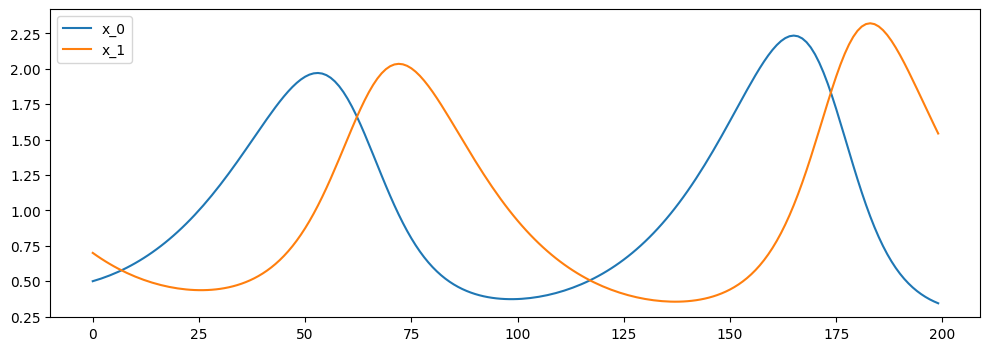

In [4]:
t_span = [0,200]
t_eval = np.arange(*t_span)

x_init = casadi.DM([0.5,0.7]) # 初期値

F = make_F()

X = [x_init]
x_current = x_init
for t in t_eval:
    x_current = F(x=x_current,u=0)["x_next"]
    X.append(x_current)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)

plt.figure(figsize=(12,4))

plt.subplot(1,1,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.savefig("images/chap4_mpc_no_control.png")
plt.show()

# コスト関数

In [5]:
def compute_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_terminal_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

# 最適化問題

In [6]:
def make_nlp():
    F = make_F()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k])
        eq = X[k+1] - F(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    option = {'print_time':False,'ipopt':{'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

# 制御入力の計算

In [7]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

# MPC

In [8]:
S = make_nlp()

In [9]:
t_span = [0,200]
t_eval = np.arange(*t_span,1)

x_init = casadi.DM([0.5,0.7]) # 初期値
x0 = casadi.DM.zeros(total)

F = make_F()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = F(x=x_current,u=u_opt)["x_next"]
    X.append(x_current)
    U.append(u_opt)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



# 結果の可視化

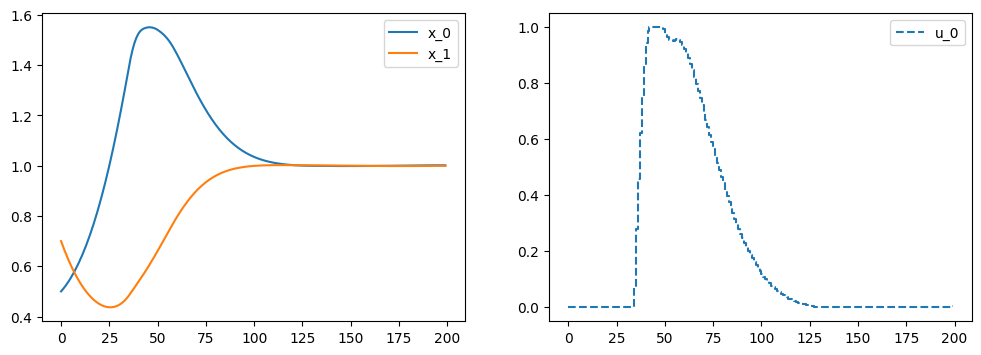

In [10]:
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.savefig("images/chap4_mpc.png")
plt.show()